In [1]:
empirical = replicate(6000, sum(rexp(n = 3)))

mean(empirical)

sd(empirical)

sum(empirical <= 5)/length(empirical)

[1] 2.965751

[1] 1.747176

[1] 0.8763333

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

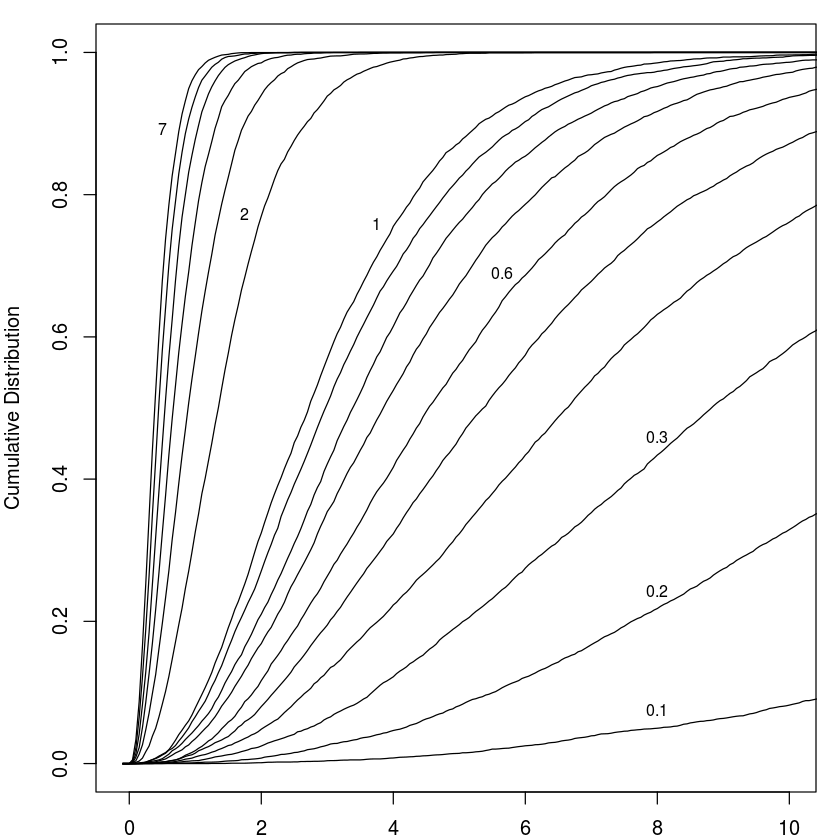

In [1]:
rates = c(seq(0.1, 1, by = 0.1), seq(2, 7, by = 1))

samples = lapply(rates, function(r) {
             replicate(6000, sum(rexp(n = 3, rate = r))) })

# pdf("BA_MCexample.pdf", width = 8, height = 5)
par(mar = c(2,4,1,1))
plot(0, 0, xlim = c(-0.1, 10), ylim = c(0, 1), pch = ".",
     xlab="", ylab="Cumulative Distribution")
xx = seq(-0.1, 20, by = 0.05)

invisible(lapply(samples[-(19:20)], function(s) {
  Fn = ecdf(s)
  ptile = Fn(xx)
  points(x = xx, y = ptile, type = "l")
}))

labs = c(1, 2, 3, 6, 10, 11, 16)
xs = c(8,8,8,6, 4, 2, 0.75)
poss = c(3,3,3, 2, 2, 2,2)
mapply(function(lab, s, x, r, p) 
  {
  Fn = ecdf(s)
  text(x = x, y = Fn(x), labels = r, pos = p, cex = 0.8)
}, lab = labs, s = samples[labs], x = xs, r = rates[labs], p = poss)

# dev.off()

In [3]:
seedx = 116201412
set.seed(seedx)

kappa = 0.3
d0 = rexp(1, rate = kappa)
d0

[1] 8.38445

In [4]:
lambda = 0.5
birth1 = rexp(1, rate = lambda)
birth1

[1] 1.470129

In [5]:
itime = c(birth1, rexp(1, rate = lambda))
itime

[1] 1.470129 4.084104

In [6]:
itime = c(itime, rexp(1, rate = lambda))
itime

cumsum(itime)

[1] 1.470129 4.084104 2.052150

[1] 1.470129 5.554233 7.606383

In [7]:
itime = c(itime, rexp(1, rate = lambda))
btime = cumsum(itime)
btime

[1]  1.470129  5.554233  7.606383 10.867862

In [8]:
btime = btime[ btime < d0 ]

dtime = d0 + rexp(n = length(btime), rate = kappa) 
dtime

[1]  9.877187  9.204891 24.551785

In [9]:
btime[1] + rexp(1, rate = lambda)

dtime[1] + rexp(1, rate = kappa)

[1] 6.233543

[1] 12.55685

In [10]:
genKids = 
function(bTime, cTime, lambda = 0.5, kappa = 0.3) 
{
         # Parent job born at bTime and completes at cTime
    
         # Birth time of first child
    mostRecent = rexp(1, rate = lambda) + bTime
    kidBirths = numeric()

    while (mostRecent < cTime) {
      kidBirths = c(kidBirths, mostRecent)
      mostRecent = mostRecent  + rexp(1, rate = lambda) 
    }
    
         # generate lifetimes for all offspring
    numKids = length(kidBirths)
    runtime = rexp(numKids, rate = kappa)
    kidCompletes = rep(cTime, numKids) + runtime
    
    data.frame(births = kidBirths, 
               completes = kidCompletes)
}

In [11]:
set.seed(seedx)

genKids(1, 6)

genKids(1, 6)

genKids(1, 6)

births,completes


births,completes
2.470129,9.42025


births,completes
4.261479,13.939024
5.157121,8.679662
5.649385,8.624457


In [12]:
genBirth = function(currentTime, cTime, 
                    births = numeric(), lambda = 0.5) {
          
         # Generate birth time of next job after currentTime
    mostRecent = rexp(1, rate = lambda) + currentTime
    
    if (mostRecent > cTime) 
      return(births)
    else {
      births = c(births, mostRecent)
      genBirth(currentTime = mostRecent, cTime, births, lambda)
    }
  }

In [13]:
genKidsR = 
function(bTime, cTime, lambda = 0.5, kappa = 0.3) {
         # Parent job born at bTime and completes at cTime
    
    kidBirths = genBirth(bTime, cTime, lambda = lambda)
    
         # generate lifetimes for all offspring
    numKids = length(kidBirths)
    runtime = rexp(numKids, rate = kappa)
    kidDeaths = rep(cTime, numKids) + runtime
    
    data.frame(births = kidBirths, 
               completes = kidDeaths)
} 

In [14]:
set.seed(seedx)

numKids = replicate(1000, nrow(genKids(1, 6)))
mean(numKids)

[1] 2.503

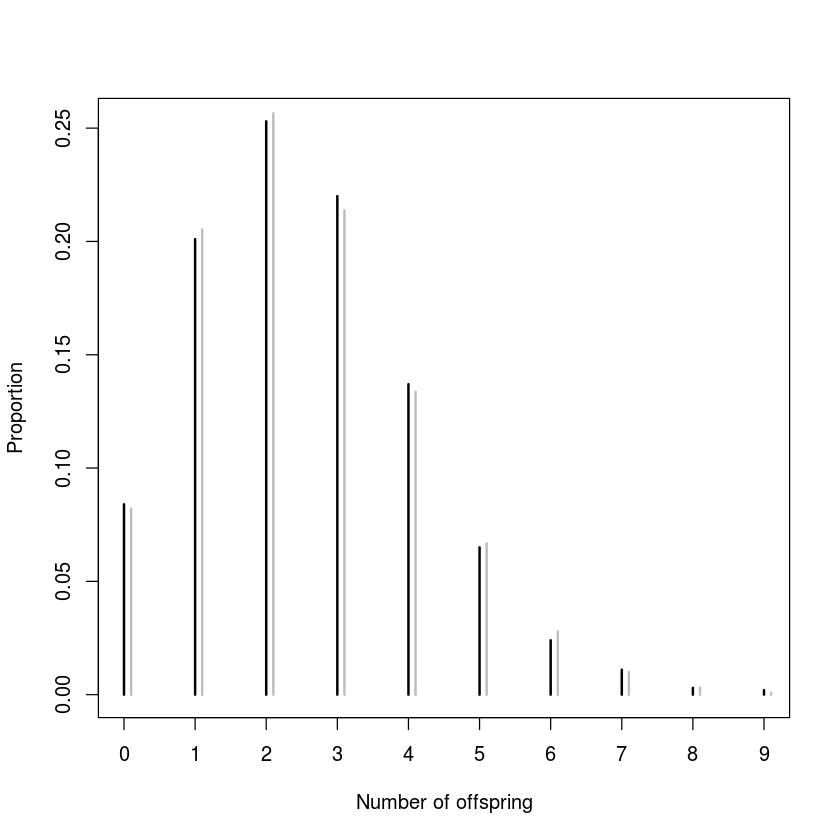

In [18]:
eprobs = table(numKids)/length(numKids)
probs = dpois(x = 0:max(numKids), lambda = 2.5)

plot(eprobs, type = "h",
     ylab = "Proportion", xlab = "Number of offspring")
segments(x0 = 0.1 + 0:max(numKids), y0 = rep(0, max(numKids)), 
         y1 = probs, col="grey", lwd = 2)

In [19]:
#chi square goodness of fit test
obsCt = table(numKids)
expCt = 1000* c(dpois(0:8, lambda = 2.5), 
                ppois(8, lower.tail = FALSE, lambda = 2.5))
stat = sum((obsCt - expCt)^2/expCt)
pchisq(stat, df = 9, lower.tail = FALSE)

[1] 0.9943803

In [20]:
genKidsU = 
  function(bTime, cTime, lambda = 0.5, kappa = 0.3) {
         # Generate the birth times and assassination times
         # for the children of a job who is born at bTime 
         # and completed at cTime.
    lambda = (cTime - bTime) * lambda
    numKids = rpois(1, lambda = lambda)
    kidBirths = sort(runif(numKids, min = bTime, max = cTime))
    
         # generate lifetimes for each offspring
    runtime = rexp(numKids, rate = kappa)
    kidDeaths = rep(cTime, numKids) + runtime
    
    return(data.frame(births = kidBirths, completes = kidDeaths))
  }

In [21]:
seedx = 116201412
set.seed(seedx)

time1 = system.time( replicate(4000, genKids(1, cTime = 9)) )
time2 = system.time( replicate(4000, genKidsU(1, cTime = 9)) )

time1/time2

time1 = system.time( replicate(4000, genKids(1, cTime = 100)) )
time2 = system.time( replicate(4000, genKidsU(1, cTime = 100)) )
time1/time2

    user   system  elapsed 
1.094708 1.500000 1.084411 

    user   system  elapsed 
1.573265      NaN 1.583173 

In [22]:
#using Rprof to profile the while-loop version of the code
set.seed(seedx)
Rprof("profGenKids1.out")
invisible( replicate(1000, genKids(1, cTime = 100)) )
Rprof(NULL)

summaryRprof("profGenKids1.out")$by.self

,self.time,self.pct,total.time,total.pct
"""rexp""",0.20,35.71,0.20,35.71
"""make.names""",0.06,10.71,0.12,21.43
"""c""",0.06,10.71,0.06,10.71
"""structure""",0.06,10.71,0.06,10.71
"""genKids""",0.02,3.57,0.56,100.00
"""data.frame""",0.02,3.57,0.30,53.57
"""as.data.frame.numeric""",0.02,3.57,0.14,25.00
"""order""",0.02,3.57,0.06,10.71
""".deparseOpts""",0.02,3.57,0.04,7.14
"""as.list""",0.02,3.57,0.02,3.57


In [23]:
set.seed(seedx)
Rprof("profGenKidsU.out")
invisible( replicate(1000, genKidsU(1, cTime = 100)) )
Rprof(NULL)
summaryRprof("profGenKidsU.out")$by.self

,self.time,self.pct,total.time,total.pct
"""structure""",0.04,15.38,0.04,15.38
"""data.frame""",0.02,7.69,0.16,61.54
"""as.data.frame.numeric""",0.02,7.69,0.12,46.15
"""sort""",0.02,7.69,0.10,38.46
"""sort.default""",0.02,7.69,0.08,30.77
"""deparse""",0.02,7.69,0.06,23.08
"""sort.int""",0.02,7.69,0.06,23.08
"""order""",0.02,7.69,0.04,15.38
"""pmatch""",0.02,7.69,0.04,15.38
"""as.character""",0.02,7.69,0.02,7.69


In [24]:
genKidsV = function(bTimes, cTimes, lambda = 0.5, kappa = 0.3) {
       # bTimes & cTimes - vector of birth and completion times

       # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), 
                  lambda = lambda*parentAge)
  
       # Determine the birth and completion times of the children
  mapply(function(n, min, max) {
            births = sort(runif(n, min, max))
            runtimes = rexp(n, rate = kappa)
            completes = rep(max, n) + runtimes
            data.frame(births, completes)
         },
         n = numKids , min = bTimes, max = cTimes,
         SIMPLIFY = FALSE)
}

In [25]:
bTimes1 = 1:3
cTimes1 = c(3, 10, 15)

seed1 = 12062013
set.seed(seed1)

kids = genKidsV(bTimes1, cTimes1)
kids

births,completes
2.936936,8.919043
births,completes
2.170295,10.31738
3.195751,15.17299
8.713876,16.03113
births,completes
3.172955,16.76033
5.496738,15.50458
9.779638,20.46424
10.325540,24.80465


In [26]:
kids2 = genKidsV(bTimes1, cTimes1)
sapply(kids2, nrow)

[1] 2 4 6

In [27]:
set.seed(seed1)
kids3 = genKidsV(bTimes = bTimes1, cTimes = cTimes1)
identical(kids, kids3)

[1] TRUE

In [28]:
genKidsV = function(bTimes, cTimes, parentID, lambda = 0.5, kappa = 0.3) {
       # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), lambda = lambda * parentAge)
  
  if (sum(numKids) == 0) return(NULL)
  
       # Determine the birth times of the children  
  kidStats = 
    mapply(function(n, min, max) {
      births = sort(runif(n, min, max))
      runtimes = rexp(n, rate = kappa)
      completes = rep(max, n) + runtimes
      data.frame(births, completes)
    },
           n = numKids , min = bTimes, max = cTimes, 
           SIMPLIFY = FALSE)
  
 
  return(data.frame(parentID = rep(parentID, numKids),
                    kidID = 1:sum(numKids), 
                    births = unlist(lapply(kidStats, "[[", "births")), 
                    completes = unlist(lapply(kidStats,"[[", "completes"))
                    ))
}

In [29]:
set.seed(seed1)
genKidsV(bTimes1, cTimes1, parentID = letters[1:3])

parentID,kidID,births,completes
a,1,2.936936,8.919043
b,2,2.170295,10.317380
b,3,3.195751,15.172991
b,4,8.713876,16.031133
c,5,3.172955,16.760326
c,6,5.496738,15.504584
c,7,9.779638,20.464240
c,8,10.325540,24.804648


In [30]:
familyTree = function(lambda = 0.5, kappa = 0.3, maxGen = 10) {
       # maxGen - maximum number of generations to observe
       # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
       # Generate the root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, births = 0,
                            completes = rexp(1, rate = kappa))
  
       # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, kappa = kappa)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ])
    allGens[[ i ]] = nextGen
  }
  
  return(allGens)
}

In [32]:
set.seed(seed1)
tree = familyTree(lambda = 0.4, kappa = 1, maxGen = 10)

Warning message in is.na(nextGen$births):
“is.na() applied to non-(list or vector) of type 'NULL'”

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

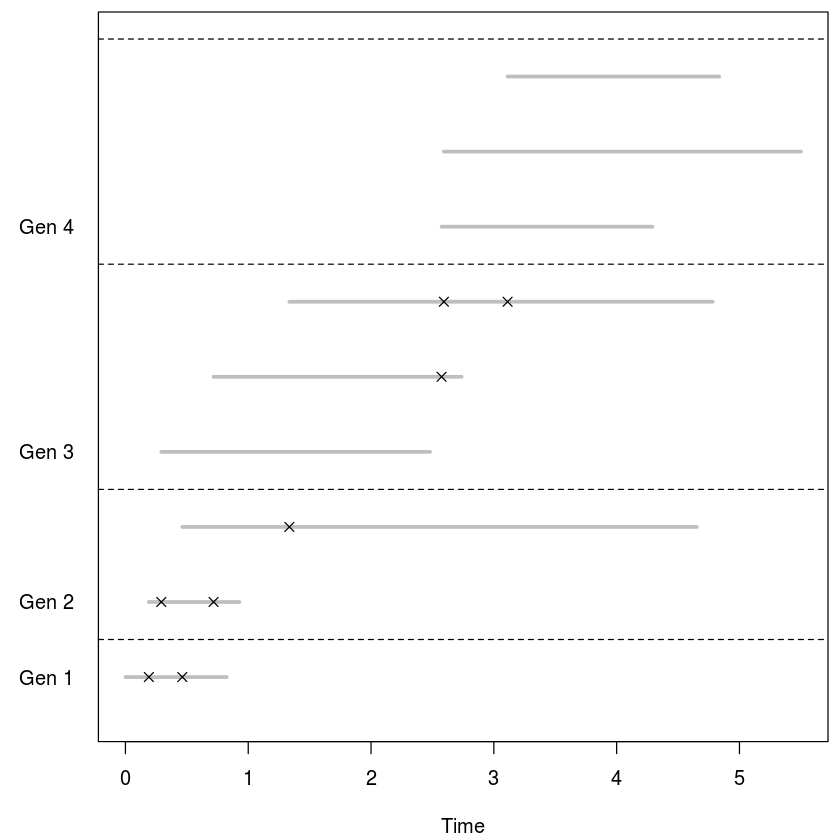

In [33]:
# pdf("BA_FamilyTree.pdf", width = 8, height = 5)
oldPar = par(mar = c(4.1, 4.1, 0.5, 0.5))

set.seed(seed1)
g = familyTree(lambda = 0.4, kappa = 1, maxGen = 10)

maxLife = max(sapply(g, function(gen) max(gen$completes)))
numFamily = sum(sapply(g, nrow))

plot(0,0, ylim = c(0.5, numFamily + 0.5), xlim = c(0, maxLife),
     xlab = "Time", ylab = "", type ="n",
     axes = FALSE)

box()
axis(1)
numGen = length(g)
numKids = sapply(g, nrow)
treeN = g[ 2:(numGen + 1) ]
birthNum = c(0, cumsum(sapply(g, nrow))[ -length(g)])
axis(2, at = birthNum + 1, 
     labels = paste("Gen", 1:numGen), tick = FALSE, las = 1)

mapply(function(gen, nextGen, birthNum) {
  birthOrder = birthNum + (1:nrow(gen))
  segments(x0 = gen$births, x1 = gen$completes, y0 = birthOrder,
          lwd = 3, col = "grey")
  abline(h = 0.5 + max(birthOrder), lty = 2, col="black" )
  if (all(!is.na(nextGen$births)))
  points(x = nextGen$births, y = birthOrder[nextGen$parentID],
         pch = 4)
  },
  gen = g, nextGen = treeN, birthNum = birthNum )
par(oldPar)
# dev.off()

In [34]:
seed2 = 12212013
set.seed(seed2)
tree = familyTree(lambda = 0.3, kappa = 0.5, maxGen = 10)

#num generations total
length(tree)

#how many children per generation?
sapply(tree, nrow)

#total number of children over all generations
sum(sapply(tree, nrow))

[1] 10

[1]   1   1   1   5   7   5  13  39  81 147

[1] 300

In [35]:
set.seed(seed2)
tree = familyTree(lambda = 0.3, kappa = 0.5, maxGen = 15)
sapply(tree[ - (1:9) ], nrow)

[1]  147  286  572 1130 2231 4666

In [36]:
set.seed(seed2)
tree = familyTree(lambda = 1, kappa = 0.5, maxGen = 10)

length(tree)

sapply(tree, nrow)

sum(sapply(tree, nrow))

[1] 10

[1]      1      3      7     19     99    464   2616  15155  90848 561791

[1] 671003

In [37]:
tree = familyTree(lambda = 1, kappa = 0.5, maxGen = 10)
sum(sapply(tree, nrow))

sapply(tree, function(gen) range(gen$births))

sapply(tree, function(gen) range(gen$completes))

[1] 989086

0,0.009460001,0.3108085,0.5372426,1.033442,1.661756,2.055077,3.311186,3.967747,4.095898
0,0.009460001,3.3884639,6.6886600,12.624078,20.301736,27.312525,37.166142,49.842720,58.438001


0.2136832,4.476301,5.257532,5.934544,6.46038,6.852209,7.282368,7.944772,8.343729,9.490732
0.2136832,4.476301,8.428051,13.091012,21.98339,27.514912,37.433661,50.030282,58.562122,70.258593


In [38]:
familyTreeT = function(lambda = 0.5, kappa = 0.3, maxTime = 8) {
       # maxTime - maximum length of time to observe the process
  allGens = list()
  
       # Generate the root of the 
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = rexp(1, rate = kappa))
  
       # Generate the future generations, one at a time.
  numGens = 1
  while (TRUE) {
    nextGen = genKidsV(bTimes = allGens[[ numGens ]]$births,
                       cTimes = allGens[[ numGens ]]$completes,
                       parentID = allGens[[ numGens ]]$kidID,
                       lambda = lambda, kappa = kappa)
    
    if ( is.null(nextGen) | (min(nextGen$births) > maxTime) ) {
           # If complete after maxTime set complete to NA
      allGens = lapply(allGens, function(gen) {
        gen$completes[ gen$completes > maxTime ] = NA
        gen
      })
      return(allGens)
    }
    
    # Drop those born after maxTime 
    nextGen = nextGen[ nextGen$births <= maxTime , ]
    nextGen$kidID = 1:nrow(nextGen)
    numGens = numGens + 1
    allGens[[ numGens ]] = nextGen    
  }  
}	

In [39]:
familyTree = function(lambda = 0.5, kappa = 0.3, 
                      maxGen = 10, maxOffspring = 1000) {

       # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
       # Generate root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = rexp(1, rate = kappa))
  
  currentNumOffspring = 0

       # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, kappa = kappa)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ]) 
    allGens[[ i ]] = nextGen
    currentNumOffspring = currentNumOffspring + nrow(nextGen)
    if (currentNumOffspring > maxOffspring) 
      return(allGens[1:i])
  }  
  allGens
}

In [40]:
set.seed(seed2)
tree = familyTree(lambda = 1, kappa = 0.5, 
                  maxGen = 100, maxOffspring = 1000)

length(tree)

sapply(tree, nrow)

sum(sapply(tree, nrow))

[1] 7

[1]    1    3    7   19   99  464 2616

[1] 3209

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

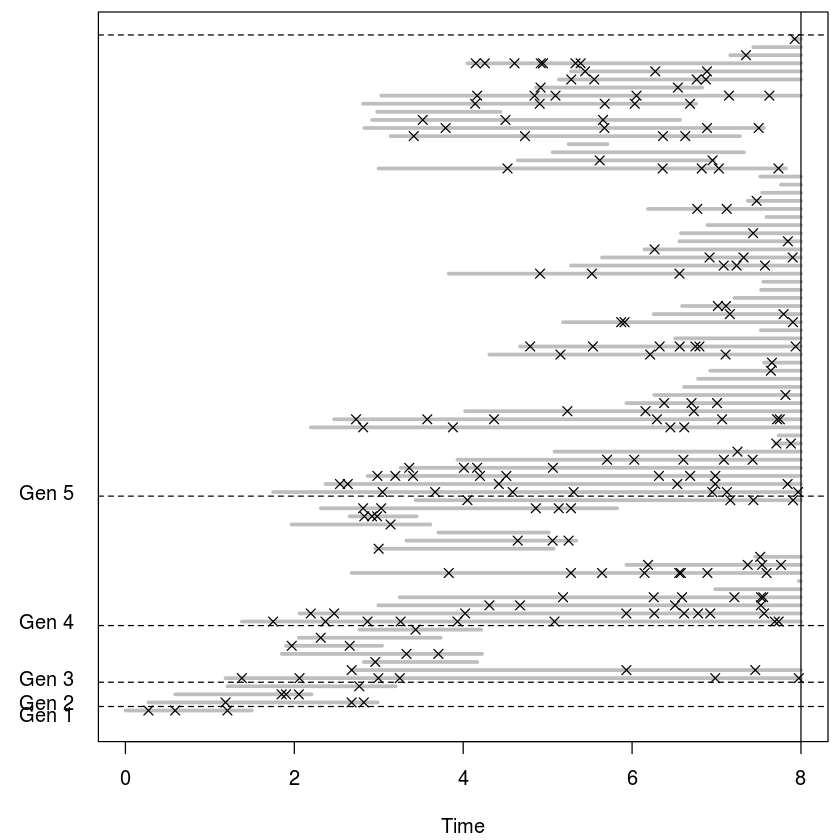

In [41]:
set.seed(seed2)
treeVT = familyTreeT(lambda = 1, kappa = 0.5)

numGen = 5
treeSub = treeVT[1:numGen]
numKids = sapply(treeSub, nrow)
numFamily = sum(numKids)

treeSub = lapply(treeSub, 
                 function(gen) {
                   gen$completes[ is.na(gen$completes) ] = 8
                   gen
                   })

treeSubN = treeVT[ 2:(numGen + 1) ]
treeSubN = lapply(treeSubN, 
                  function(gen) {
                    gen$completes[ is.na(gen$completes) ] = 8
                    gen
                 })
  
maxLife = max(sapply(treeSub, function(gen) max(gen$completes)))

birthNum = c(0, cumsum(numKids)[ -numGen ])

# pdf("BA_FamilyTreeVT.pdf", width = 8, height = 15)
oldPar = par(mar = c(4.1, 4.1, 0.5, 0.5))

plot(0,0, ylim = c(0.5, numFamily), xlim = c(0, maxLife),
     xlab = "Time", ylab = "", type ="n",
     axes = FALSE)

box()
axis(1)
axis(2, at = birthNum + c(0.5, rep(1, (numGen-1))), 
     labels = paste("Gen", 1:numGen), tick = FALSE, las = 1)

mapply(function(gen, nextGen, birthNum) {
  birthOrder = birthNum + (1:nrow(gen))
  segments(x0 = gen$births, x1 = gen$completes, y0 = birthOrder,
           lwd = 3, col = "grey")
  abline(h = 0.5 + max(birthOrder), lty = 2, col="black" )
  points(x = nextGen$births, y = birthOrder[nextGen$parentID],
           pch = 4)
}, gen = treeSub, nextGen = treeSubN, birthNum = birthNum )

abline(v = maxLife)

par(oldPar)
# dev.off()

In [42]:
exptOne = function(l, k, mG, mO){
       # Helper function to call familyTree
       # Returns - summary statistics for analysis,
  
  aTree = familyTree(lambda = l, kappa = k, maxGen = mG,
                      maxOffspring = mO)
  numGen = length(aTree)
  numJobs = sum(sapply(aTree, nrow))
  c(numGen, numJobs)
}

In [43]:
set.seed(seed2)
exptOne(1, 0.5, 100, 1000)

[1]    7 3209

In [44]:
familyTreeT = function(lambda = 0.5, kappa = 0.3, maxTime = 8) {
  # maxTime - maximum length of time to observe the family
  allGens = list()
  
  # Generate the root of the 
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = rexp(1, rate = kappa))
  
  # Generate the future generations, one at a time.
  numGens = 1
  while (TRUE) {
    nextGen = genKidsV(bTimes = allGens[[ numGens ]]$births,
                       cTimes = allGens[[ numGens ]]$completes,
                       parentID = allGens[[ numGens ]]$kidID,
                       lambda = lambda, kappa = kappa)
    
    treeTerminated = is.null(nextGen)
    if ( !treeTerminated ) {
      birthsPastObsTime = min(nextGen$births) > maxTime
    }
    else birthsPastObsTime = TRUE
    
    if ( treeTerminated | birthsPastObsTime ) {
      # If complete after maxTime set complete to NA
      allGens = lapply(allGens, function(gen) {
        gen$completes[ gen$completes > maxTime ] = NA
        gen
      })
      return(allGens)
    }
    
    # Drop those born after maxTime 
    nextGen = nextGen[ nextGen$births <= maxTime , ]
    nextGen$kidID = 1:nrow(nextGen)
    numGens = numGens + 1
    allGens[[ numGens ]] = nextGen    
  }  
}

In [45]:
MCBA = function(params, repeats = 5, mG = 10, mO = 1000){
       # params: matrix columns of lambda and kappa values
       # For each lambda and kappa pair, run "repeats" times
  
  n = nrow(params)
  mcResults = vector("list", length = n)
  
  for (i in 1:n) {
    cat("param set is ", i, "\n")
    mcResults[[i]] = replicate(repeats,
                               exptOne(l = params[i, 1],
                                       k = params[i, 2],
                                       mG = mG, mO = mO))
  }
  mcResults
}

In [46]:
trialKappas = c(0.1, 10, 0.1, 10)
trialLambdas = c(0.1, 0.1, 10, 10)
trialParams = matrix(c(trialLambdas, trialKappas), ncol = 2)
mcTrialOutput = MCBA(params = trialParams, repeats = 100, 
                     mG = 200, mO = 100000)

param set is  1 
param set is  2 
param set is  3 
param set is  4 


In [47]:
save(mcTrialOutput, file = "mcTrialOutput.rda")

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

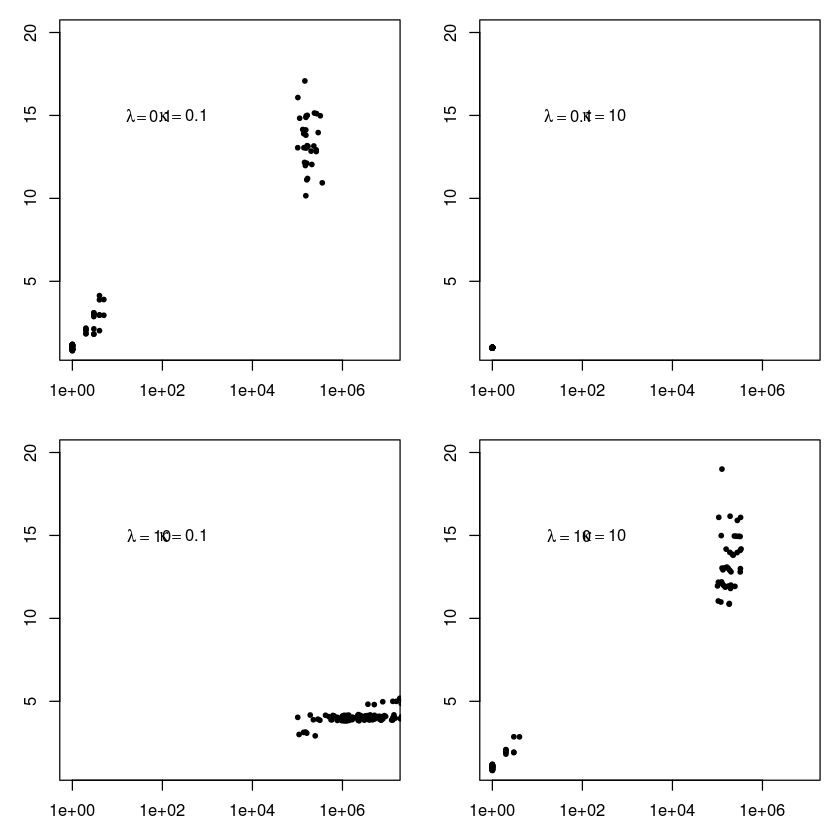

In [48]:
# pdf("BA_ScatterPlotNumGenByNumKids.pdf", width = 10, height = 8)

oldPar = par(mfrow = c(2, 2), mar = c(3,3,1,1))

mapply(function(oneSet, lambda, kappa) {
  plot(x = oneSet[2,], y = jitter(oneSet[1, ], 1), log = "x",
       ylim = c(1,20), xlim = c(1, 10^7), pch = 19, cex = 0.6)
  text(x = 50, y = 15, bquote(paste(lambda == .(lambda))) )
  text(x = 300, y = 15, bquote(paste(kappa == .(kappa))) )
  }, 
  mcTrialOutput, lambda = trialLambdas, kappa = trialKappas)

par(oldPar)

# dev.off()

In [ ]:
lambdas = c(seq(0.1, 0.6, by = 0.1), seq(0.8, 2, by = 0.2), 
            seq(2.25, 3, by = 0.25))
kappas = c(lambdas, 3.25, 3.50, 3.75, 4.00, 4.50, 5.00)

paramGrid = as.matrix(expand.grid(lambdas, kappas))

# pdf("BA_Scatterplot3Dkids.pdf", width = 7, height = 6)

mcGrid = MCBA(params = paramGrid, repeats = 400, mG = 20,
                mO = 1000)

save(mcGrid, file = "mcGridOutput.rda")

In [54]:
logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )
color3 = c("#b3cde3aa", "#8856a7aa", "#810f7caa")
colors = color3[UQCut]

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set is  27 
param set is  28 
param set is  29 
param set is  30 
param set is  31 
param set is  32 
param set is  33 
param set is  34 
param set is  35 
param set is  36 
param set is  37 
param set is  38 
param set is  39 
param set is  40 
param set is  41 
param set is  42 
param set is  43 
param set is  44 
param set is  45 
param set is  46 
param set is  47 
param set is  48 
param set is  49 
param set is  50 
param set is  51 
param set is  52 
param set is  53 
param set is  54 
param set is  55 
param set is  56 
p

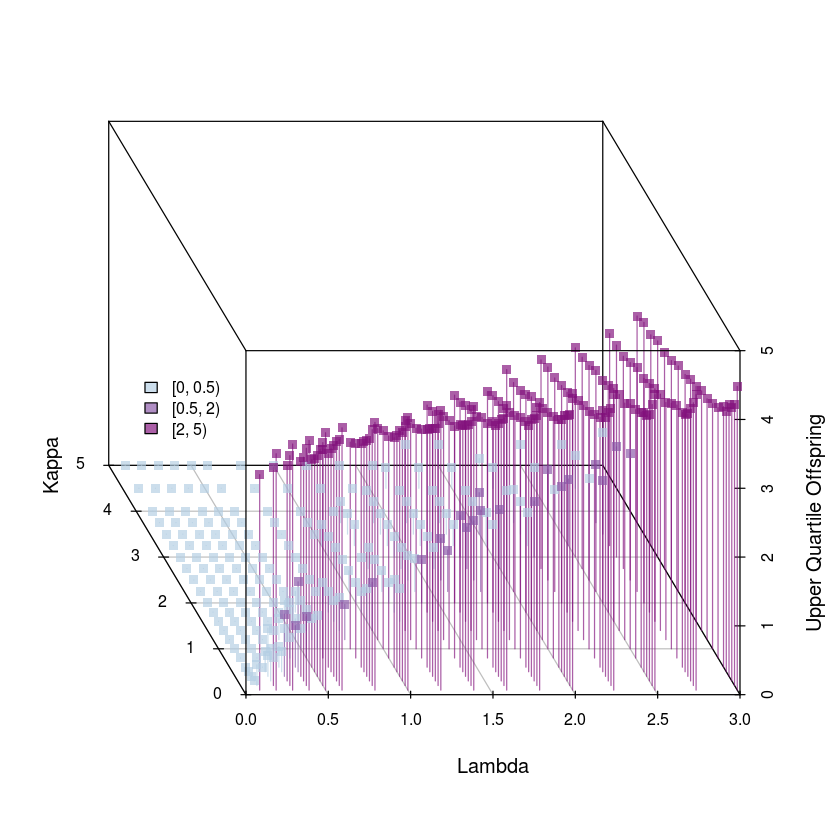

In [51]:
library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                    z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Kappa",
                    zlab = "Upper Quartile Offspring",
                    angle = 120, type="h")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 5)"), 
       fill = color3)

# dev.off()

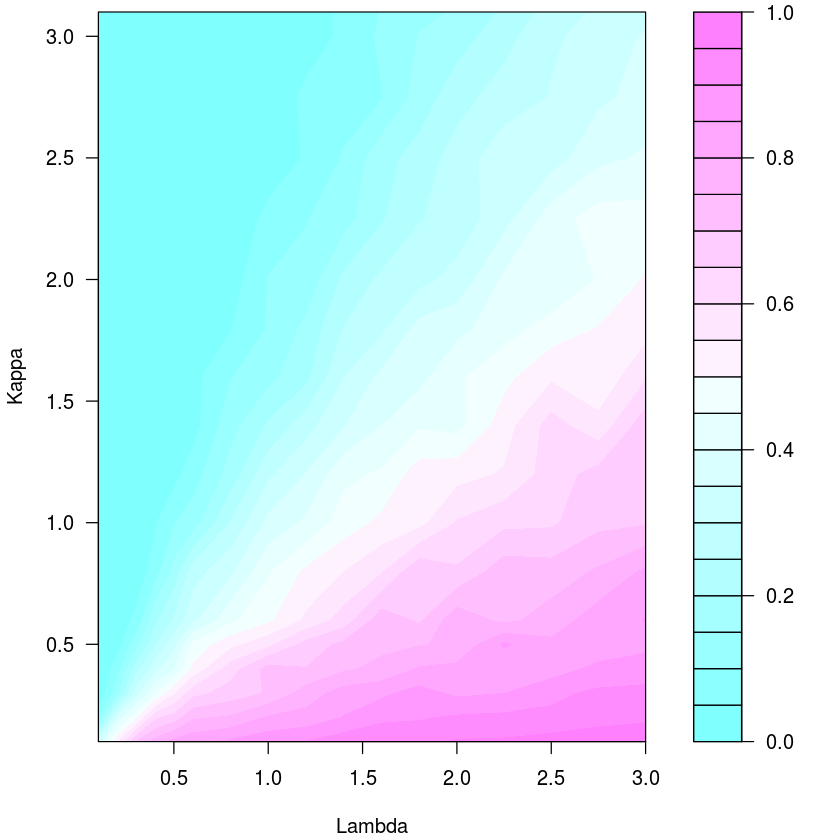

In [52]:
# pdf("BA_ImageMapAlive.pdf", width = 7, height = 7)
oldPar  = par(mar = c(4.1, 4.1, 0.5, 0.5))

mcGridAlive = sapply(mcGrid, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

filled.contour(lambdas, kappas, 
               matrix(mcGridAlive, nrow = length(lambdas), 
                      ncol = length(kappas)), 
               xlab = "Lambda", ylab = "Kappa", 
               xlim = c(0.1, 3), ylim = c(0.1, 3.1)) 

par(oldPar)
# dev.off()

ERROR: Error in legend(x = 0.1, y = 3.25, legend = midBreaks, fill = cols, bty = "n", : object 'cols' not found


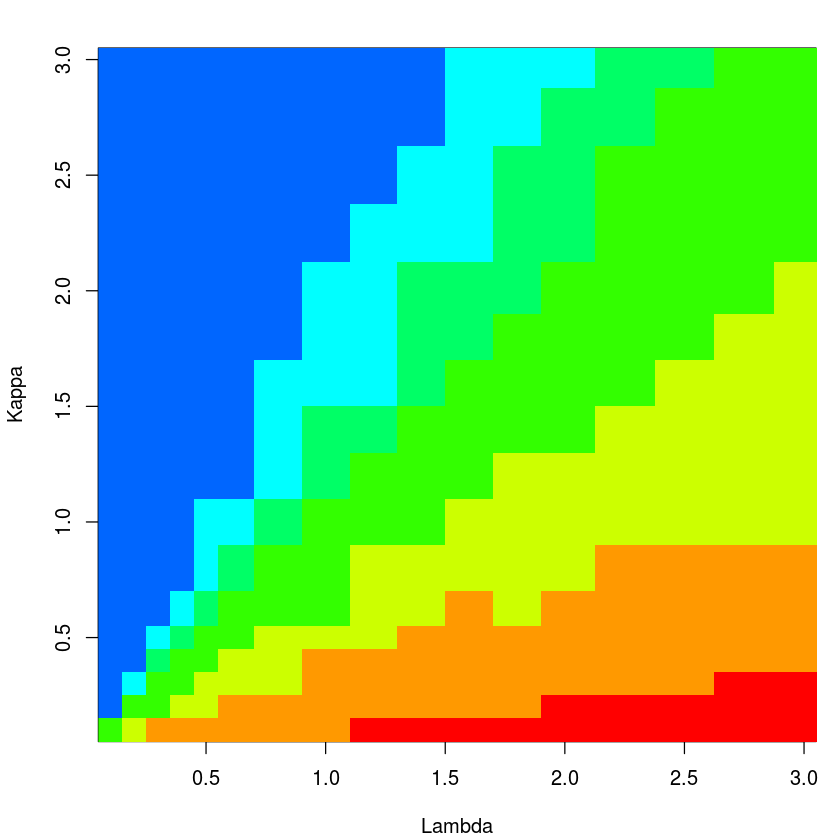

In [53]:
# pdf("BA_ImageMapAtleast20Kids.pdf", width = 7, height = 7)
oldPar  = par(mar = c(4.1, 4.1, 2, 1))

mcGridProp20kids = sapply(mcGrid, function(oneParamSet) {
  sum(oneParamSet[2,] > 19) / length(oneParamSet[2,]) })

mcGridProp20kidsMat = matrix(mcGridProp20kids, 
                             nrow = length(lambdas), 
                             ncol = length(kappas))

breaks = c(0, 0.10, 0.2, 0.3, 0.5, 0.7, 0.9, 1)
colors = rev(rainbow(10))[-(1:3)]

image(lambdas, kappas, mcGridProp20kidsMat, col = colors,
      breaks = breaks, xlab = "Lambda", ylab = "Kappa", 
      xlim = c(0.05, 3.05), ylim = c(0.05, 3.05))

midBreaks = (breaks[ -8 ] + breaks[ -1 ]) / 2
legend(x = 0.1, y = 3.25, legend = midBreaks, fill = colors, 
       bty = "n", ncol = 7,  xpd = TRUE)

par(oldPar)
# dev.off()